In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgbm
import gc
import xgboost as xgb

In [3]:
items           = pd.read_csv('items.csv')
item_categories = pd.read_csv('item_categories.csv')
shops           = pd.read_csv('shops.csv')
sales_train     = pd.read_csv('sales_train_v2.csv')
test            = pd.read_csv('test.csv')
sample_submission            = pd.read_csv('sample_submission.csv')

In [4]:
transactions = sales_train.copy()
transactions[['day','month', 'year']] = transactions['date'].str.split('.', expand=True).astype(int)


In [5]:
w_cat_ids = transactions.set_index('item_id').join(items.set_index('item_id'))
w_cat_ids = w_cat_ids.reset_index()
w_cat_ids['row_id'] = w_cat_ids.index

In [6]:
w_cat_ids['item_shop_count_block'] = w_cat_ids.groupby(['date_block_num', 'shop_id', 'item_id'])['item_cnt_day'].transform('sum').clip(0,20)

In [220]:
global_mean = w_cat_ids.groupby(['date_block_num','shop_id','item_id'])['item_cnt_day'].sum().mean()
block_nums = w_cat_ids['date_block_num'].nunique()
number_of_shops =  w_cat_ids['shop_id'].nunique()
total_sold = w_cat_ids['item_cnt_day'].sum()

In [9]:
w_cat_ids['shop_global_mean'] = w_cat_ids.groupby(['shop_id'])['shop_id'].transform('nunique')
w_cat_ids['shop_count_block'] = w_cat_ids.groupby(['shop_id','date_block_num'])['item_cnt_day'].transform('sum')
w_cat_ids['item_count_block'] = w_cat_ids.groupby(['item_id','date_block_num'])['item_cnt_day'].transform('sum')

w_cat_ids['cat_count_block'] = w_cat_ids.groupby(['item_category_id','date_block_num'])['item_cnt_day'].transform('sum')
w_cat_ids['shop_cat_count_block'] = w_cat_ids.groupby(['date_block_num','shop_id','item_category_id'])['item_cnt_day'].transform('sum')

In [10]:
avg_items_ids_unique = w_cat_ids.groupby(['date_block_num', 'shop_id'])['item_id'].nunique().groupby(level=1).mean().reset_index(name='avg_items_ids_unique')
avg_items_ids_unique
w_cat_ids = pd.merge(w_cat_ids, pd.DataFrame(avg_items_ids_unique), on=['shop_id'], how='left')

In [11]:
w_cat_ids['number_shops_selling_item'] = w_cat_ids.groupby(['item_id'])['shop_id'].transform('nunique')
w_cat_ids['number_items_in_cat'] = w_cat_ids.groupby(['item_category_id'])['item_id'].transform('nunique')
w_cat_ids['item_ids_linked_to_shop'] = w_cat_ids.groupby(['shop_id'])['item_id'].transform('nunique')
w_cat_ids['mean_unique_items_shop_month'] = w_cat_ids.groupby(['date_block_num', 'shop_id'])['item_id'].transform('nunique')
w_cat_ids['avg_items_ids_unique'] = w_cat_ids.groupby(['shop_id', 'date_block_num'])['item_id'].nunique().mean()

In [12]:
w_cat_ids['shop_mean'] = w_cat_ids.groupby(['shop_id'])['shop_count_block'].transform('mean') / w_cat_ids['item_ids_linked_to_shop']

In [13]:
w_cat_ids['item_shop_block_mean'] = w_cat_ids.groupby(['shop_id', 'item_id'])['item_shop_count_block'].transform('mean')



w_cat_ids['shop_cat_month_mean'] = w_cat_ids.groupby(['month','shop_id','item_category_id'])['shop_cat_count_block'].transform('mean') / w_cat_ids['number_items_in_cat']
w_cat_ids['item_month_mean'] = w_cat_ids.groupby(['month','item_id'])['item_count_block'].transform('mean') / w_cat_ids['number_shops_selling_item']
w_cat_ids['cat_month_mean'] = w_cat_ids.groupby(['month','item_category_id'])['item_count_block'].transform('mean') / w_cat_ids['number_items_in_cat']
w_cat_ids['shop_month_mean'] = w_cat_ids.groupby(['month','shop_id'])['shop_count_block'].transform('mean') / w_cat_ids['avg_items_ids_unique']


In [14]:
#gc.collect()
#w_cat_ids['tmp'] = w_cat_ids.groupby(['item_id', 'date_block_num'])['item_cnt_day'].transform('sum')
#w_cat_ids['rolling_item_month_mean'] = w_cat_ids.sort_values(['date_block_num']).groupby(['date_block_num','item_id']).first()['item_month_mean'].rolling(3).mean().reset_index(drop=True) 
#w_cat_ids[(w_cat_ids.shop_id == 31) & (w_cat_ids.item_id==20949)].sort_values(['date_block_num']).groupby([  'item_id'])['item_count_block'].rolling(3).mean().reset_index(drop=True) 



In [15]:
lags = [1,2]

for lag in lags:
    lags = w_cat_ids.sort_values(by='date_block_num').groupby(['item_id', 'date_block_num'])['item_month_mean'].first().groupby(level=[0]).shift(lag)
    w_cat_ids.set_index(['item_id', 'date_block_num'], inplace=True)
    w_cat_ids["item_month_mean_minus_%d" % (lag)]  = lags
    w_cat_ids.reset_index(inplace=True)

In [16]:
lags = [1,2]

for lag in lags:
    lags = w_cat_ids.sort_values(by='date_block_num').groupby(['shop_id', 'date_block_num'])['shop_month_mean'].first().groupby(level=[0]).shift(lag)
    w_cat_ids.set_index(['shop_id', 'date_block_num'], inplace=True)
    w_cat_ids["shop_month_mean_minus_%d" % (lag)]  = lags
    w_cat_ids.reset_index(inplace=True)

In [17]:
lags = [1,2]

for lag in lags:
    lags = w_cat_ids.sort_values(by='date_block_num').groupby(['shop_id', 'item_category_id', 'date_block_num'])['shop_cat_month_mean'].first().groupby(level=[0,1]).shift(lag)
    w_cat_ids.set_index(['shop_id', 'item_category_id', 'date_block_num'], inplace=True)
    w_cat_ids["shop_cat_month_mean_minus_%d" % (lag)]  = lags
    w_cat_ids.reset_index(inplace=True)

In [18]:
w_cat_ids['item_month_mean_minus_1'] = w_cat_ids['item_month_mean_minus_1'].fillna(w_cat_ids['item_month_mean'])
w_cat_ids['item_month_mean_minus_2'] = w_cat_ids['item_month_mean_minus_2'].fillna(w_cat_ids['item_month_mean'])

w_cat_ids['shop_month_mean_minus_1'] = w_cat_ids['shop_month_mean_minus_1'].fillna(w_cat_ids['shop_month_mean'])
w_cat_ids['shop_month_mean_minus_2'] = w_cat_ids['shop_month_mean_minus_2'].fillna(w_cat_ids['shop_month_mean'])

In [19]:
#w_cat_ids.groupby(['shop_id','item_id', 'date_block_num'])['item_shop_block_mean'].first()
w_cat_ids['first_block'] = w_cat_ids.groupby(['shop_id','item_id'])['date_block_num'].transform('min')

In [20]:
def get_last_year(block):
    if block < 12:
        return 0
    return block - 12

w_cat_ids['block_previous_year'] = w_cat_ids['date_block_num'].apply(lambda block: get_last_year(block))

In [25]:
means = w_cat_ids.sort_values(['date_block_num']).groupby(['item_id','date_block_num']).first()['item_month_mean'].rolling(3).mean().reset_index(name='rolling_item_month_mean')
#means
w_cat_ids = pd.merge(w_cat_ids, pd.DataFrame(means), on=['item_id','date_block_num'], how='left')

In [243]:



w_cat_ids['item_id_mean_enc'] = w_cat_ids.groupby(['item_id'])['item_cnt_day'].transform('sum') / w_cat_ids['item_cnt_day'].sum()
w_cat_ids['cat_id_mean_enc'] = w_cat_ids.groupby(['item_category_id'])['item_cnt_day'].transform('sum') / w_cat_ids['item_cnt_day'].sum()
w_cat_ids['shop_id_mean_enc'] = w_cat_ids.groupby(['shop_id'])['item_cnt_day'].transform('sum') / w_cat_ids['item_cnt_day'].sum()



# Fill NaNs
#w_cat_ids['mean_enc_kfold'].fillna(global_mean, inplace=True) 

In [253]:
import datetime
months = []
for i in range(1,13):
    months.append((i, str.lower(datetime.date(2008, i, 1).strftime('%B'))))
    
for i, month in months:
    w_cat_ids[month] = w_cat_ids.month == i
    
years = w_cat_ids.year.unique()
for year in years:
    w_cat_ids[year] = w_cat_ids.year == year

In [262]:
def get_coeffs_for_shop(shop_id, poly_degree=1, print_chart=False):

    shop = w_cat_ids[w_cat_ids.shop_id == shop_id].groupby('date_block_num')['item_cnt_day'].sum().reset_index(name ='item_cnt')

    datax = shop.date_block_num.values
    datay = shop.item_cnt.values

    z = np.polyfit(datax,datay, poly_degree) 
    p = np.poly1d(z)

    shop['poly'] = shop['date_block_num'].apply(lambda x: p(x))

    if print_chart:
        sns.set()
        fig, ax = plt.subplots()
        shop.plot(x='date_block_num', y='item_cnt', ax=ax, legend=False, figsize=(15,7))
        shop.plot(x='date_block_num', y='poly', ax=ax, legend=False, figsize=(15,7))

    return p

def get_coeffs_for_category(category_id, poly_degree=1, print_chart=False):

    cat = w_cat_ids[w_cat_ids.item_category_id == category_id].groupby('date_block_num')['item_cnt_day'].sum().reset_index(name ='item_cnt')

    datax = cat.date_block_num.values
    datay = cat.item_cnt.values

    z = np.polyfit(datax,datay, poly_degree) 
    p = np.poly1d(z)

    cat['poly'] = cat['date_block_num'].apply(lambda x: p(x))

    if print_chart:
        sns.set()
        fig, ax = plt.subplots()
        cat.plot(x='date_block_num', y='item_cnt', ax=ax, legend=False, figsize=(15,7))
        cat.plot(x='date_block_num', y='poly', ax=ax, legend=False, figsize=(15,7))

    return p

def get_coeffs_for_item(item_id, poly_degree=1, print_chart=False):

    cat = w_cat_ids[w_cat_ids.item_id == item_id].groupby('date_block_num')['item_cnt_day'].sum().reset_index(name ='item_cnt')

    datax = cat.date_block_num.values
    datay = cat.item_cnt.values

    z = np.polyfit(datax,datay, poly_degree) 
    p = np.poly1d(z)

    cat['poly'] = cat['date_block_num'].apply(lambda x: p(x))

    if print_chart:
        sns.set()
        fig, ax = plt.subplots()
        cat.plot(x='date_block_num', y='item_cnt', ax=ax, legend=False, figsize=(15,7))
        cat.plot(x='date_block_num', y='poly', ax=ax, legend=False, figsize=(15,7))

    return p

In [263]:
shop_ids = w_cat_ids.shop_id.unique()
slopes = {}

for shop_id in shop_ids:
    slope = get_coeffs_for_shop(shop_id)[0]
    slopes[shop_id] = slope

w_cat_ids['shop_slope'] = w_cat_ids.apply(lambda row: slopes[row['shop_id']], axis=1)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  


In [264]:
cat_ids = w_cat_ids.item_category_id.unique()
slopes = {}

for cat_id in cat_ids:
    slope = get_coeffs_for_category(cat_id)[0]
    slopes[cat_id] = slope

w_cat_ids['cat_slope'] = w_cat_ids.apply(lambda row: slopes[row['item_category_id']], axis=1)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: RankWarning: Polyfit may be poorly conditioned


In [265]:
item_ids = w_cat_ids.item_id.unique()
slopes = {}

#for item_id in item_ids:
    #slope = get_coeffs_for_item(item_id)[0]
    #slopes[item_id] = slope
    
import pickle
#with open('item_slope.pickle', 'wb') as handle:
    #pickle.dump(slopes, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('item_slope.pickle', 'rb') as handle:
    slopes = pickle.load(handle)

w_cat_ids['item_slope'] = w_cat_ids.apply(lambda row: slopes[row['item_id']], axis=1)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly cond

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly cond

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly cond

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly cond

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly cond

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly cond

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly cond

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly cond

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly cond

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly cond

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly cond

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly cond

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly cond

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly cond

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly cond

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly cond

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly cond

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly cond

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly cond

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly cond

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly cond

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly cond

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly cond

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly cond

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly cond

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly cond

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly cond

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly cond

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly cond

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly cond

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly cond

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly cond

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly cond

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly cond

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly cond

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly cond

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly cond

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly cond

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RankWarning: Polyfit may be poorly cond

In [284]:
w_cat_ids['shop_item_block_sum'] = w_cat_ids.groupby(['date_block_num','shop_id','item_id'])['item_cnt_day'].transform('sum')


In [286]:
w_cat_ids['shop_item_month_mean'] = w_cat_ids.groupby(['month','shop_id','item_id'])['shop_item_block_sum'].transform('mean')

In [287]:
lags = [1,2]

for lag in lags:
    lags = w_cat_ids.sort_values(by='date_block_num').groupby(['shop_id', 'item_id', 'date_block_num'])['shop_item_month_mean'].first().groupby(level=[0,1]).shift(lag)
    w_cat_ids.set_index(['shop_id', 'item_id', 'date_block_num'], inplace=True)
    w_cat_ids["shop_item_month_mean_minus_%d" % (lag)]  = lags
    w_cat_ids.reset_index(inplace=True)

In [274]:
w_cat_ids['shop_item_feature_1'] = w_cat_ids['item_month_mean'] / w_cat_ids['shop_month_mean']

In [355]:
q3_means = w_cat_ids[w_cat_ids['month'].isin([10,11,12])].groupby(['shop_id','item_id'])['shop_item_block_sum'].mean().reset_index(name='q3_mean')

w_cat_ids = pd.merge(w_cat_ids, q3_means, on=['shop_id','item_id'], how='left')

In [439]:
w_cat_ids['default_shop_item_month_mean'] = w_cat_ids.groupby(['shop_id','item_category_id'])['shop_item_month_mean'].transform('mean')

In [439]:
w_cat_ids['default_default_shop_item_month_mean'] = w_cat_ids.groupby(['shop_id','item_category_id'])['shop_item_month_mean'].transform('mean')

In [440]:
w_cat_ids[['item_shop_count_block',
            'item_month_mean','cat_month_mean', 'shop_month_mean', 'rolling_item_month_mean', 'item_month_mean_minus_1',\
           'item_month_mean_minus_2', 'shop_month_mean_minus_1', 'shop_month_mean_minus_2', 'item_month_mean_previous_year', 'shop_month_mean_previous_year',\
           'shop_cat_month_mean', 'shop_cat_month_mean_minus_1', 'shop_cat_month_mean_minus_2', 'item_id_mean_enc_kfold', 'item_slope', 'shop_slope', 'cat_slope',\
           'shop_item_feature_1', 'shop_item_month_mean', 'shop_item_month_mean_minus_1', 'shop_item_month_mean_minus_2', 'q3_mean', 'default_shop_item_month_mean']].corr()

,item_shop_count_block,item_month_mean,cat_month_mean,shop_month_mean,rolling_item_month_mean,item_month_mean_minus_1,item_month_mean_minus_2,shop_month_mean_minus_1,shop_month_mean_minus_2,item_month_mean_previous_year,...,item_id_mean_enc_kfold,item_slope,shop_slope,cat_slope,shop_item_feature_1,shop_item_month_mean,shop_item_month_mean_minus_1,shop_item_month_mean_minus_2,q3_mean,default_shop_item_month_mean
item_shop_count_block,1.000000,0.427883,0.314714,0.172088,0.413056,0.459791,0.455693,0.150488,0.141077,0.487681,...,0.345888,0.354000,0.139167,-0.010241,0.352928,0.440480,0.423220,0.425895,0.354965,0.305687
item_month_mean,0.427883,1.000000,0.666537,-0.049349,0.856779,0.804868,0.746222,-0.059693,-0.064649,0.977920,...,0.690899,0.472990,-0.075969,-0.062992,0.787344,0.761209,0.572984,0.528405,0.641542,0.567301
cat_month_mean,0.314714,0.666537,1.000000,-0.038391,0.699128,0.687093,0.644246,-0.042461,-0.046160,0.769291,...,0.872637,0.458428,-0.043832,-0.093082,0.618425,0.549640,0.568807,0.550904,0.583617,0.606210
shop_month_mean,0.172088,-0.049349,-0.038391,1.000000,-0.056353,-0.061605,-0.062615,0.924525,0.894722,-0.058038,...,-0.052742,-0.057758,0.927088,0.017071,-0.121996,0.069839,0.052563,0.038304,0.041861,0.064835
rolling_item_month_mean,0.413056,0.856779,0.699128,-0.056353,1.000000,0.881824,0.858664,-0.057301,-0.060733,0.930604,...,0.763053,0.572120,-0.074893,-0.070568,0.751646,0.662391,0.686094,0.679491,0.636456,0.587806
item_month_mean_minus_1,0.459791,0.804868,0.687093,-0.061605,0.881824,1.000000,0.854988,-0.058551,-0.066002,0.859641,...,0.758738,0.574670,-0.078232,-0.060420,0.722262,0.626262,0.729532,0.639353,0.636748,0.564908
item_month_mean_minus_2,0.455693,0.746222,0.644246,-0.062615,0.858664,0.854988,1.000000,-0.063303,-0.060264,0.802417,...,0.743907,0.570618,-0.077664,-0.052712,0.688354,0.585992,0.615414,0.728046,0.619519,0.545967
shop_month_mean_minus_1,0.150488,-0.059693,-0.042461,0.924525,-0.057301,-0.058551,-0.063303,1.000000,0.932362,-0.062102,...,-0.052433,-0.058902,0.938344,0.026814,-0.123430,0.057336,0.061900,0.043750,0.041441,0.064859
shop_month_mean_minus_2,0.141077,-0.064649,-0.046160,0.894722,-0.060733,-0.066002,-0.060264,0.932362,1.000000,-0.067328,...,-0.052892,-0.060579,0.942165,0.030580,-0.124679,0.051677,0.050592,0.049763,0.038423,0.064709
item_month_mean_previous_year,0.487681,0.977920,0.769291,-0.058038,0.930604,0.859641,0.802417,-0.062102,-0.067328,1.000000,...,0.833794,0.827784,-0.074637,-0.081936,0.750818,0.731443,0.643190,0.614812,0.668793,0.642391


In [357]:
 w_cat_ids[(w_cat_ids.shop_id == 31) & (w_cat_ids.item_id==20949)].groupby('date_block_num').first().sort_values(by='date_block_num')\
    [['item_month_mean','cat_month_mean', 'shop_month_mean', 'rolling_item_month_mean', 'shop_mean', 'item_month_mean_minus_1',\
           'item_month_mean_minus_2', 'shop_month_mean_minus_1', 'shop_month_mean_minus_2', 'item_month_mean_previous_year', 'shop_month_mean_previous_year', \
     'shop_cat_month_mean', 'shop_cat_month_mean_minus_1', 'shop_cat_month_mean_minus_2', 'item_id_mean_enc_kfold',  'shop_item_month_mean', \
      'shop_item_month_mean_minus_1', 'shop_item_month_mean_minus_2','q3_mean']]

,item_month_mean,cat_month_mean,shop_month_mean,rolling_item_month_mean,shop_mean,item_month_mean_minus_1,item_month_mean_minus_2,shop_month_mean_minus_1,shop_month_mean_minus_2,item_month_mean_previous_year,shop_month_mean_previous_year,shop_cat_month_mean,shop_cat_month_mean_minus_1,shop_cat_month_mean_minus_2,item_id_mean_enc_kfold,shop_item_month_mean,shop_item_month_mean_minus_1,shop_item_month_mean_minus_2,q3_mean
date_block_num,,,,,,,,,,,,,,,,,,,
3,93.982355,829.770005,8.631911,31.355821,0.670324,93.982355,93.982355,10.118020,9.507010,NaN,9.585090,84.489247,132.806452,NaN,0.066303,506.935484,NaN,NaN,902.776744
4,87.536805,771.803121,7.968017,60.513479,0.670324,93.982355,87.536805,8.631911,10.118020,NaN,9.585090,80.692308,84.489247,132.806452,0.066303,484.153846,506.935484,NaN,902.776744
5,123.096018,1086.642656,8.127062,101.538393,0.670324,87.536805,93.982355,7.968017,8.631911,NaN,9.585090,101.222222,80.692308,84.489247,0.066303,607.333333,484.153846,506.935484,902.776744
6,109.065224,963.409477,7.659349,106.566016,0.670324,123.096018,87.536805,8.127062,7.968017,NaN,9.585090,100.500000,101.222222,80.692308,0.066303,603.000000,607.333333,484.153846,902.776744
7,111.598567,985.787344,8.169069,114.586603,0.670324,109.065224,123.096018,7.659349,8.127062,NaN,9.585090,102.611111,100.500000,101.222222,0.066303,615.666667,603.000000,607.333333,902.776744
8,117.442884,1037.412142,8.985024,112.702225,0.670324,111.598567,109.065224,8.169069,7.659349,NaN,9.585090,114.555556,102.611111,100.500000,0.066303,687.333333,615.666667,603.000000,902.776744
9,119.096597,1052.019936,8.643509,116.046016,0.670324,117.442884,111.598567,8.985024,8.169069,NaN,9.585090,113.500000,114.555556,102.611111,0.066303,681.000000,687.333333,615.666667,902.776744
10,153.308829,1354.227992,10.698922,129.949437,0.670324,119.096597,117.442884,8.643509,8.985024,NaN,9.585090,146.750000,113.500000,114.555556,0.066303,880.500000,681.000000,687.333333,902.776744
11,233.370245,2061.437167,15.280018,168.591890,0.670324,153.308829,119.096597,10.698922,8.643509,NaN,9.585090,209.500000,146.750000,113.500000,0.066303,1257.000000,880.500000,681.000000,902.776744


In [130]:
columns = w_cat_ids.columns
percent_missing = w_cat_ids.isna().sum() * 100 / len(w_cat_ids)
pd.DataFrame({'column_name': columns,
                                 'percent_missing': percent_missing})

,column_name,percent_missing
shop_id,shop_id,0.000000
item_category_id,item_category_id,0.000000
date_block_num,date_block_num,0.000000
item_id,item_id,0.000000
date,date,0.000000
item_price,item_price,0.000000
item_cnt_day,item_cnt_day,0.000000
day,day,0.000000
month,month,0.000000
year,year,0.000000


In [500]:
w_cat_ids.columns

Index([                               'shop_id',
                                      'item_id',
                               'date_block_num',
                             'item_category_id',
                                         'date',
                                   'item_price',
                                 'item_cnt_day',
                                          'day',
                                        'month',
                                         'year',
                                    'item_name',
                                       'row_id',
                        'item_shop_count_block',
                             'shop_global_mean',
                             'shop_count_block',
                             'item_count_block',
                              'cat_count_block',
                         'shop_cat_count_block',
                         'avg_items_ids_unique',
                    'number_shops_selling_item',
                    

In [502]:
features = [#'shop_id',  'item_id',  'item_category_id'
        #'month', 'year', 'date_block_num',
      'january',
                                     'february',
                                        'march',
                                        'april',
                                          'may',
                                         'june',
                                         'july',
                                       'august',
                                    'september',
                                      'october',
                                     'november',
                                     'december',
                                           2014,
                                           2015,
                                           2013,
            'item_id_mean_enc', 'cat_id_mean_enc', 'shop_id_mean_enc',
       'shop_global_mean',
       #'number_shops_selling_item', 'number_items_in_cat',
       #'item_ids_linked_to_shop',
       #'shop_mean', 
            'item_month_mean',
       'cat_month_mean', 'shop_month_mean', 'item_month_mean_minus_1',
       'item_month_mean_minus_2', 'shop_month_mean_minus_1',
       'shop_month_mean_minus_2', 'rolling_item_month_mean',
       #'item_month_mean_previous_year',
       #'shop_month_mean_previous_year',
        'shop_cat_month_mean', 'shop_cat_month_mean_minus_1', 'shop_cat_month_mean_minus_2',
    'item_slope', 'shop_slope', 'cat_slope', 'shop_item_feature_1',
     'shop_item_month_mean', 'shop_item_month_mean_minus_1', 'shop_item_month_mean_minus_2',
    'q3_mean'

]

In [293]:
 w_cat_ids[features].head(10)

,january,february,march,april,may,june,july,august,september,october,...,shop_cat_month_mean,shop_cat_month_mean_minus_1,shop_cat_month_mean_minus_2,item_slope,shop_slope,cat_slope,shop_item_feature_1,shop_item_month_mean,shop_item_month_mean_minus_1,shop_item_month_mean_minus_2
0,False,False,False,False,False,False,False,False,True,False,...,0.306649,0.327917,0.317649,0.500000,8923.330049,31092.415126,0.150870,1.0,NaN,NaN
1,False,False,False,True,False,False,False,False,False,False,...,0.555992,0.568536,0.539184,4.358491,96.330441,118.822321,0.795571,2.0,NaN,NaN
2,False,False,False,True,False,False,False,False,False,False,...,0.555992,0.568536,0.539184,4.358491,96.330441,118.822321,0.795571,2.0,NaN,NaN
3,False,False,False,False,False,False,True,False,False,False,...,0.567667,0.457675,0.416716,4.358491,96.330441,118.822321,0.744918,1.0,2.0,NaN
4,False,False,False,False,False,False,False,True,False,False,...,0.624268,0.567667,0.457675,4.358491,96.330441,118.822321,0.617364,1.0,1.0,2.0
5,False,False,False,False,False,False,False,False,True,False,...,0.656762,0.624268,0.567667,4.358491,96.330441,118.822321,0.266270,1.0,1.0,1.0
6,False,False,False,False,False,False,False,False,False,True,...,0.701559,0.656762,0.624268,4.358491,96.330441,118.822321,0.366948,1.0,1.0,1.0
7,False,False,False,False,False,False,False,True,False,False,...,0.327917,0.317649,0.367501,1.000000,8923.330049,31092.415126,0.142951,1.0,NaN,NaN
8,False,False,False,False,False,False,False,False,False,False,...,0.351287,0.291351,0.306649,1.000000,8923.330049,31092.415126,0.139438,1.0,1.0,NaN
9,False,False,False,False,False,False,True,False,False,False,...,0.317649,0.367501,0.360025,1.000000,8923.330049,31092.415126,0.159746,1.0,NaN,NaN


In [32]:
# categories test
cat_counts_test = pd.DataFrame(test_w_cat_ids.groupby('item_category_id').size().reset_index(name="counts"))
cat_counts_test['percentage'] = cat_counts_test['counts'] * 100 / cat_counts_test.counts.sum()

# categories train
cat_counts = pd.DataFrame(w_cat_ids.groupby('item_category_id').size().reset_index(name="counts"))
cat_counts['percentage'] = cat_counts['counts'] * 100 / cat_counts.counts.sum()

combined  = pd.merge(cat_counts, cat_counts_test,  how='left', left_on=['item_category_id'], right_on = ['item_category_id'])
combined = combined.rename(index= str, columns={"counts_x": "total_train", "percentage_x": "%train", "counts_y": "total_test", "percentage_y": "%test"})

shares = {}
for _, row in combined.iterrows():
    shares[row['item_category_id']] = row['%test']

no_nans = [v for v in shares.values() if not np.isnan(v)] 
#sorted(no_nans, reverse=True)

val_len = 25000

    
def get_share_of_group(group):
    #print(type(group))
    cat_id = np.unique(group[['item_category_id']])[0]
    share = shares[cat_id]

    #print(share)
    needed = val_len * share / 100
    #print(needed)

    if len(group) <= needed:
        print("Needed %d but only %d available for cat_id %d with share %f" % (needed, len(group), cat_id, share))
    #else:
        #print("OK")
    if np.isnan(needed):
        return group.head(0)
    return group.head(int(needed))


#val_indices = w_cat_ids[w_cat_ids['date_block_num'].isin([32,33])].groupby("item_category_id").apply(get_share_of_group).index
val_indices = w_cat_ids[w_cat_ids['date_block_num'].isin([32,33])].groupby("item_category_id").apply(get_share_of_group)['row_id'].values

Needed 4 but only 1 available for cat_id 27 with share 0.019608
Needed 171 but only 145 available for cat_id 45 with share 0.686275
Needed 1093 but only 820 available for cat_id 58 with share 4.372549
Needed 39 but only 33 available for cat_id 60 with share 0.156863
Needed 299 but only 241 available for cat_id 76 with share 1.196078
Needed 78 but only 66 available for cat_id 77 with share 0.313725
Needed 240 but only 134 available for cat_id 78 with share 0.960784


In [574]:
x = w_cat_ids[features] 
y = w_cat_ids['item_shop_count_block']


x_train = x[~x.index.isin(val_indices)]
y_train = y[~y.index.isin(val_indices)]

x_val = x[x.index.isin(val_indices)]
y_val = y[y.index.isin(val_indices)]

In [575]:
lgtrain = lgbm.Dataset(x_train, label=y_train)
lgval = lgbm.Dataset(x_val, label=y_val)



#[0.00542047893814942, 29, 24, 0.39949465609514856, 1, 0.67943500, 10]
params = {
        "num_threads": 8,
        "verbosity": -1,
        #"zero_as_missing": "true",
        "boosting":'gbdt',
        "objective" : "regression",
        "metric" : "rmse",
        "seed": 42,
        "learning_rate" : 0.05
}

evals_result = {}
model_lgb = lgbm.train(params, lgtrain, 10000, 
                      valid_sets=[lgval], 
                      early_stopping_rounds=100, 
                      verbose_eval=100, 
                      evals_result=evals_result)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.00161
[200]	valid_0's rmse: 0.96534
[300]	valid_0's rmse: 0.958763
[400]	valid_0's rmse: 0.945408
[500]	valid_0's rmse: 0.937885
[600]	valid_0's rmse: 0.932002
[700]	valid_0's rmse: 0.929265
[800]	valid_0's rmse: 0.927854
Early stopping, best iteration is:
[776]	valid_0's rmse: 0.927759


In [542]:
test_w_cat_ids = test.set_index('item_id').join(items.set_index('item_id'))
test_w_cat_ids['item_id'] = test_w_cat_ids.index

In [543]:
test_w_cat_ids['month'] = 11
test_w_cat_ids['year'] = 2015
test_w_cat_ids['date_block_num'] = 34

In [544]:
len(test_w_cat_ids)

214200

In [545]:
item_level = w_cat_ids.drop_duplicates(['item_id'])[['item_id','item_id_mean_enc', 'item_slope']]

test_w_cat_ids = pd.merge(test_w_cat_ids, item_level, on=['item_id'], how='left')

In [546]:
shop_level = w_cat_ids.drop_duplicates(['shop_id'])[['shop_id','shop_global_mean', 'shop_id_mean_enc', 'shop_slope']]

test_w_cat_ids = pd.merge(test_w_cat_ids, shop_level, on=['shop_id'], how='left')

In [547]:
cat_level = w_cat_ids.drop_duplicates(['item_category_id'])[['item_category_id','cat_id_mean_enc', 'cat_slope']]

test_w_cat_ids = pd.merge(test_w_cat_ids, cat_level, on=['item_category_id'], how='left')

In [548]:
item_month_level = w_cat_ids[(w_cat_ids.month == 11)].drop_duplicates(['item_id'])[['item_id','item_month_mean','rolling_item_month_mean']]

test_w_cat_ids = pd.merge(test_w_cat_ids, item_month_level, on=['item_id'], how='left')

In [549]:
item_month_level_fallback_1 = w_cat_ids[(w_cat_ids.month == 10)].drop_duplicates(['item_id'])[['item_id','item_month_mean','rolling_item_month_mean']]\
                                   .copy().rename(columns={'item_month_mean':'item_month_mean_fallback_1', 'rolling_item_month_mean':'rolling_item_month_mean_fallback_1'})


test_w_cat_ids = pd.merge(test_w_cat_ids, item_month_level_fallback_1, on=['item_id'], how='left')

In [550]:
def fallback1(row, col):
    if pd.isnull(row[col]):
        return row['%s_fallback_1' % (col)]
    return row[col]

test_w_cat_ids['item_month_mean'] = test_w_cat_ids.apply(lambda row: fallback1(row, 'item_month_mean'), axis=1)
test_w_cat_ids['rolling_item_month_mean'] = test_w_cat_ids.apply(lambda row: fallback1(row, 'rolling_item_month_mean'), axis=1)

In [551]:
item_month_level_ = w_cat_ids[(w_cat_ids.month == 10)].drop_duplicates(['item_id'])[['item_id','item_month_mean']]\
                                   .copy().rename(columns={'item_month_mean':'item_month_mean_minus_1'})

test_w_cat_ids = pd.merge(test_w_cat_ids, item_month_level_, on=['item_id'], how='left')

In [552]:
item_month_level__ = w_cat_ids[(w_cat_ids.month == 9)].drop_duplicates(['item_id'])[['item_id','item_month_mean']]\
                                   .copy().rename(columns={'item_month_mean':'item_month_mean_minus_2'})

test_w_cat_ids = pd.merge(test_w_cat_ids, item_month_level__, on=['item_id'], how='left')

In [553]:
cat_month_level = w_cat_ids[(w_cat_ids.month == 11)].drop_duplicates(['item_category_id', 'month'])[['item_category_id','cat_month_mean']]

test_w_cat_ids = pd.merge(test_w_cat_ids, cat_month_level, on=['item_category_id'], how='left')

In [554]:
shop_month_level = w_cat_ids[(w_cat_ids.month == 11)].drop_duplicates(['shop_id'])[['shop_id','shop_month_mean']]

test_w_cat_ids = pd.merge(test_w_cat_ids, shop_month_level, on=['shop_id'], how='left')

In [555]:
shop_month_level_ = w_cat_ids[(w_cat_ids.month == 10)].drop_duplicates(['shop_id'])[['shop_id','shop_month_mean']]\
                                   .copy().rename(columns={'shop_month_mean':'shop_month_mean_minus_1'})

test_w_cat_ids = pd.merge(test_w_cat_ids, shop_month_level_, on=['shop_id'], how='left')

In [556]:
shop_month_level__ = w_cat_ids[(w_cat_ids.month == 9)].drop_duplicates(['shop_id'])[['shop_id','shop_month_mean']]\
                                   .copy().rename(columns={'shop_month_mean':'shop_month_mean_minus_2'})

test_w_cat_ids = pd.merge(test_w_cat_ids, shop_month_level__, on=['shop_id'], how='left')

In [557]:
shop_cat_month_level = w_cat_ids[(w_cat_ids.month == 11)].drop_duplicates(['item_category_id', 'shop_id'])[['item_category_id', 'shop_id', 'shop_cat_month_mean']]

test_w_cat_ids = pd.merge(test_w_cat_ids, shop_cat_month_level, on=['item_category_id', 'shop_id'], how='left')

In [558]:
shop_cat_month_level_ = w_cat_ids[(w_cat_ids.month == 10)].drop_duplicates(['item_category_id', 'shop_id'])[['item_category_id', 'shop_id', 'shop_cat_month_mean']]\
                                   .copy().rename(columns={'shop_cat_month_mean':'shop_cat_month_mean_minus_1'})


test_w_cat_ids = pd.merge(test_w_cat_ids, shop_cat_month_level_, on=['item_category_id', 'shop_id'], how='left')

In [559]:
shop_item_month_level = w_cat_ids[(w_cat_ids.month == 11)].drop_duplicates(['item_id', 'shop_id'])[['item_id', 'shop_id', 'shop_item_feature_1',\
                                                                                                    'shop_item_month_mean', 'shop_item_month_mean_minus_1', 'shop_item_month_mean_minus_2']]

test_w_cat_ids = pd.merge(test_w_cat_ids, shop_item_month_level, on=['item_id', 'shop_id'], how='left')

In [560]:
shop_item_month_level_ = w_cat_ids.drop_duplicates(['item_id', 'shop_id'])[['item_id', 'shop_id', 'q3_mean', 'default_shop_item_month_mean']]

test_w_cat_ids = pd.merge(test_w_cat_ids, shop_item_month_level_, on=['item_id', 'shop_id'], how='left')

In [561]:
####

shop_item_month_level_fallback_1 = w_cat_ids[(w_cat_ids.month == 10)].drop_duplicates(['item_id', 'shop_id'])[['item_id', 'shop_id', 'shop_item_feature_1', 'shop_item_month_mean' ]]\
                                   .copy().rename(columns={'shop_item_feature_1':'shop_item_feature_1_fallback_1', 'shop_item_month_mean':'shop_item_month_mean_fallback_1'})


test_w_cat_ids = pd.merge(test_w_cat_ids, shop_item_month_level_fallback_1, on=['item_id', 'shop_id'], how='left')

In [562]:
####

shop_item_month_level_fallback_2 = w_cat_ids[(w_cat_ids.month == 9)].drop_duplicates(['item_id', 'shop_id'])[['item_id', 'shop_id', 'shop_item_feature_1', 'shop_item_month_mean' ]]\
                                   .copy().rename(columns={'shop_item_feature_1':'shop_item_feature_1_fallback_2', 'shop_item_month_mean':'shop_item_month_mean_fallback_2'})


test_w_cat_ids = pd.merge(test_w_cat_ids, shop_item_month_level_fallback_2, on=['item_id', 'shop_id'], how='left')

In [563]:
def fallback1(row, col, n):
    if pd.isnull(row[col]):
        name = '%s_fallback_%s' % (col, n)
        #print(name)
        #print(row[name])
        return row[name]
    return row[col]

test_w_cat_ids['shop_item_month_mean'] = test_w_cat_ids.apply(lambda row: fallback1(row, 'shop_item_month_mean', 1), axis=1)
test_w_cat_ids['shop_item_feature_1'] = test_w_cat_ids.apply(lambda row: fallback1(row, 'shop_item_feature_1', 1), axis=1)

test_w_cat_ids['shop_item_month_mean'] = test_w_cat_ids.apply(lambda row: fallback1(row, 'shop_item_month_mean', 2), axis=1)
test_w_cat_ids['shop_item_feature_1'] = test_w_cat_ids.apply(lambda row: fallback1(row, 'shop_item_feature_1', 2), axis=1)



In [564]:
def fallback(row, col):
    if pd.isnull(row[col]):
        return row['default_shop_item_month_mean']
    return row[col]

test_w_cat_ids['shop_item_month_mean'] = test_w_cat_ids.apply(lambda row: fallback(row, 'shop_item_month_mean'), axis=1)


In [565]:
test_w_cat_ids['shop_cat_month_mean'] = test_w_cat_ids['shop_cat_month_mean'].fillna(test_w_cat_ids['shop_cat_month_mean_minus_1'])

In [566]:
shop_cat_month_level = w_cat_ids[(w_cat_ids.month == 9)].drop_duplicates(['item_category_id', 'shop_id'])[['item_category_id', 'shop_id', 'shop_cat_month_mean']]\
                                   .copy().rename(columns={'shop_cat_month_mean':'shop_cat_month_mean_minus_2'})


test_w_cat_ids = pd.merge(test_w_cat_ids, shop_cat_month_level, on=['item_category_id', 'shop_id'], how='left')

In [567]:
for _, month in months:
    test_w_cat_ids[month] = False
    
test_w_cat_ids['november'] = True

for year in years:
    test_w_cat_ids[year] = False
    
test_w_cat_ids[2015] = True


Index([                     'january',                     'february',
                              'march',                        'april',
                                'may',                         'june',
                               'july',                       'august',
                          'september',                      'october',
                           'november',                     'december',
                                 2014,                           2015,
                                 2013,             'item_id_mean_enc',
                    'cat_id_mean_enc',             'shop_id_mean_enc',
                   'shop_global_mean',              'item_month_mean',
                     'cat_month_mean',              'shop_month_mean',
            'item_month_mean_minus_1',      'item_month_mean_minus_2',
            'shop_month_mean_minus_1',      'shop_month_mean_minus_2',
            'rolling_item_month_mean',          'shop_cat_month_mean',
      

In [573]:
columns = test_w_cat_ids.columns
percent_missing = test_w_cat_ids.isna().sum() * 100 / len(test_w_cat_ids)
pd.DataFrame({'column_name': columns,
                                 'percent_missing': percent_missing})

,column_name,percent_missing
ID,ID,0.000000
shop_id,shop_id,0.000000
item_name,item_name,0.000000
item_category_id,item_category_id,0.000000
item_id,item_id,0.000000
month,month,0.000000
year,year,0.000000
date_block_num,date_block_num,0.000000
item_id_mean_enc,item_id_mean_enc,7.117647
item_slope,item_slope,7.117647


In [569]:
test_w_cat_ids[features]

,january,february,march,april,may,june,july,august,september,october,...,shop_cat_month_mean_minus_1,shop_cat_month_mean_minus_2,item_slope,shop_slope,cat_slope,shop_item_feature_1,shop_item_month_mean,shop_item_month_mean_minus_1,shop_item_month_mean_minus_2,q3_mean
0,False,False,False,False,False,False,False,False,False,False,...,0.043489,0.041637,209.138258,1382.318182,31092.415126,0.339237,1.000000,NaN,NaN,1.000000
1,False,False,False,False,False,False,False,False,False,False,...,0.030020,0.031785,209.138258,1712.114286,31092.415126,NaN,1.615580,NaN,NaN,NaN
2,False,False,False,False,False,False,False,False,False,False,...,0.075196,0.084325,209.138258,4208.099160,31092.415126,0.218876,1.000000,1.000000,1.000000,1.000000
3,False,False,False,False,False,False,False,False,False,False,...,0.018553,0.019374,209.138258,892.964706,31092.415126,0.771468,1.000000,1.000000,1.000000,1.500000
4,False,False,False,False,False,False,False,False,False,False,...,0.012441,0.009635,209.138258,829.793277,31092.415126,NaN,1.498504,NaN,NaN,NaN
5,False,False,False,False,False,False,False,False,False,False,...,0.059840,0.062389,209.138258,2506.173109,31092.415126,0.342354,1.000000,1.000000,8.200000,1.666667
6,False,False,False,False,False,False,False,False,False,False,...,0.021843,0.018740,209.138258,992.623939,31092.415126,NaN,1.494842,NaN,NaN,NaN
7,False,False,False,False,False,False,False,False,False,False,...,0.008967,0.004912,209.138258,1076.937815,31092.415126,NaN,1.892449,NaN,NaN,NaN
8,False,False,False,False,False,False,False,False,False,False,...,0.194517,0.212103,209.138258,7083.105882,31092.415126,0.130965,2.600000,1.000000,1.000000,2.250000
9,False,False,False,False,False,False,False,False,False,False,...,0.420746,0.394043,209.138258,11666.618487,31092.415126,0.072398,1.000000,2.333333,4.000000,5.200000


In [117]:
test_w_cat_ids.head()

,ID,shop_id,item_name,item_category_id,item_id,month_x,year,date_block_num,shop_cat_month_mean,month_y,shop_cat_month_mean_minus_1,month,shop_cat_month_mean_minus_2
0,2587,5,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,30,11,2015,34,0.054945,10.0,0.043489,9.0,0.041637
1,7687,4,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,30,11,2015,34,0.024094,10.0,0.030020,9.0,0.031785
2,12787,6,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,30,11,2015,34,0.090080,10.0,0.075196,9.0,0.084325
3,17887,3,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,30,11,2015,34,0.027800,10.0,0.018553,9.0,0.019374
4,22987,2,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,30,11,2015,34,0.009287,10.0,0.012441,9.0,0.009635


In [109]:
features

['shop_id',
 'date_block_num',
 'item_id',
 'month',
 'year',
 'item_category_id',
 'shop_global_mean',
 'shop_mean',
 'item_month_mean',
 'cat_month_mean',
 'shop_month_mean',
 'item_month_mean_minus_1',
 'item_month_mean_minus_2',
 'shop_month_mean_minus_1',
 'shop_month_mean_minus_2',
 'rolling_item_month_mean',
 'item_month_mean_previous_year',
 'shop_month_mean_previous_year',
 'shop_cat_month_mean',
 'shop_cat_month_mean_minus_1',
 'shop_cat_month_mean_minus_2']

In [576]:
preds = np.clip(model_lgb.predict(test_w_cat_ids[features]), 0,20)

In [577]:
submission = test.loc[:,['ID']]
submission['item_cnt_month'] = preds.astype(int)

submission.to_csv('submission.csv', index=False)

Plotting feature importances...


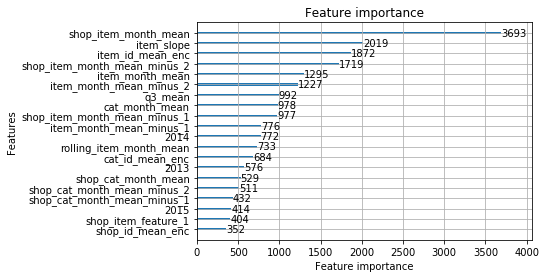

In [578]:
print('Plotting feature importances...')
ax = lgbm.plot_importance(model_lgb, max_num_features=20)
plt.show()

3.45 val > 3.70 submit
3.06 val > 3.65 submit